# Dublin Air Bnb Geoplotting

Geospatial visualisation and data analysis has long been an area of personal interest for me, but has always seemed to fall to the periphery of more standard raw data science and graphical visuals.
To try and get some handson familiarity and practice with geospatial visualisation, a good and readily accessible sourced to start with felt like __[Inside Air BnB](http://insideairbnb.com/get-the-data)__, an open source data repository focused on collecting data around Air BnB in specific city areas of various countries as a means of assessing the deeper impact of the companies property letting on urban communities

For this example, I chose to go semi-local and take a look at the Air BnB data in Dublin, which in the last decade or so, has become massively unlivable for both low to average salary earners, and especially young people. 

To begin with, two files are needed from the web page for both the raw data and the related geospatial data used to render onto a readable map; `listings.csv` and `neighbourhoods.geojson`

To begin with, run the necessary imports and read in the listings data to a pandas dataframe

In [107]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import pysal
import geoplot.crs as gcrs
import geoplot as gplt

from numpy import Inf
from folium import plugins

sns.set_theme()

dub_listings = pd.read_csv('listings.csv')
dub_listings.describe()

id       host_id  neighbourhood_group     latitude  \
count  8.440000e+03  8.440000e+03                  0.0  8440.000000   
mean   2.733412e+17  1.395853e+08                  NaN    53.345449   
std    3.738527e+17  1.507540e+08                  NaN     0.046388   
min    4.407700e+04  4.398400e+04                  NaN    53.207663   
25%    1.933922e+07  2.754379e+07                  NaN    53.327961   
50%    3.598778e+07  7.335573e+07                  NaN    53.344160   
75%    6.970116e+17  2.029741e+08                  NaN    53.357097   
max    9.101728e+17  5.191105e+08                  NaN    53.623490   

         longitude         price  minimum_nights  number_of_reviews  \
count  8440.000000   8440.000000     8440.000000        8440.000000   
mean     -6.255111    181.120498        6.184716          31.159005   
std       0.062639    562.541185       29.167667          68.372446   
min      -6.497588      9.000000        1.000000           0.000000   
25%      -6.278417     70.000000        1.000000           1.000000   
50%      -6.259215    115.000000        2.000000           6.000000   
75%      -6.233293    200.000000        4.000000          27.000000   
max      -6.052910  46513.000000     1125.000000        1218.000000   

       reviews_per_month  calculated_host_listings_count  availability_365  \
count        6689.000000                     8440.000000       8440.000000   
mean            1.291769                        5.366588         75.978791   
std             1.882547                       12.511049        111.235354   
min             0.010000                        1.000000          0.000000   
25%             0.140000                        1.000000          0.000000   
50%             0.600000                        1.000000          9.000000   
75%             1.750000                        3.000000        117.250000   
max            40.070000                       76.000000        365.000000   

       number_of_reviews_ltm  license  
count            8440.000000      0.0  
mean                8.196919      NaN  
std                19.460945      NaN  
min                 0.000000      NaN  
25%                 0.000000      NaN  
50%                 0.000000      NaN  
75%                 7.000000      NaN  
max               538.000000      NaN

Not all the features will be of use in the spatial plotting or relay much meaningful information, so just selecting some of the most pertinent properties of the rentals for the dataframe

In [108]:
cols = ['id', 'neighbourhood_group', 'latitude', 'longitude','number_of_reviews','price']
dub_listings = dub_listings[cols]

Having all the relevant columns, we can then take a look at the properties of each of the features and see how they are distributed

In [109]:
dub_listings.describe()

id  neighbourhood_group     latitude    longitude  \
count  8.440000e+03                  0.0  8440.000000  8440.000000   
mean   2.733412e+17                  NaN    53.345449    -6.255111   
std    3.738527e+17                  NaN     0.046388     0.062639   
min    4.407700e+04                  NaN    53.207663    -6.497588   
25%    1.933922e+07                  NaN    53.327961    -6.278417   
50%    3.598778e+07                  NaN    53.344160    -6.259215   
75%    6.970116e+17                  NaN    53.357097    -6.233293   
max    9.101728e+17                  NaN    53.623490    -6.052910   

       number_of_reviews         price  
count        8440.000000   8440.000000  
mean           31.159005    181.120498  
std            68.372446    562.541185  
min             0.000000      9.000000  
25%             1.000000     70.000000  
50%             6.000000    115.000000  
75%            27.000000    200.000000  
max          1218.000000  46513.000000

Looking at some of the stats on the price here, we see we've got around 8400 listed property prices. Interestingly though, we see that while the mean is around €180, but the medial is around €115. This alone normally hints at there being afew very high value entries skewing the distribution (and checking the max percentile, we see that its true; €46000 for one specific property)

To see this distribution skewness, it can be useful to do an initial histogram plot of our prices. However, since we can already be pretty sure that we have erroneus values skewing the plot, we can try taking the 97th percentile to get a measure of where 97% of all the values are falling under and plot an accompanying histogram excluding the largest entries

In [110]:
np.quantile(dub_listings['price'],0.97)

600.0

/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

<Figure size 800x800 with 0 Axes>

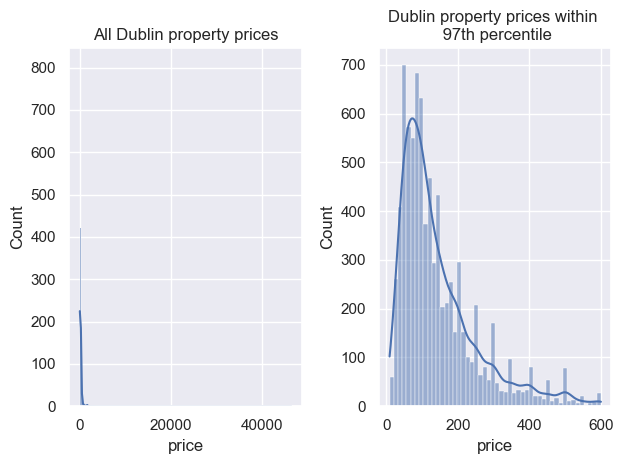

In [111]:
plt.figure(figsize=[8,8])
fig, axs = plt.subplots(1, 2)

sns.histplot(dub_listings['price'], kde=True, ax=axs[0])
sns.histplot(dub_listings.where(dub_listings.price <= 600)['price'], kde=True, ax=axs[1])

axs[0].set_title('All Dublin property prices')
axs[1].set_title('Dublin property prices within \n 97th percentile')

fig.tight_layout()

Expectedly, we can see the data is heavily right-skewed
With this in mind, we can start actually looking at displaying this data geosptially to gleen some possible relations via the geographic variation

To begin with, we can use Geopandas package. Firstly we pass it the listings dataframe complete with all the data of interest stored in it (here, price is the most readily important feature), after which to define how said data points will be displayed cartographically, the geometry is defined by reading in the Longitude, Latitude information from the listings dataframe. Along with this, we have to provide the `Geographic Coordinate System`. I'll choose to go with EPSG:4326 for here

Extra note: The coordinate system can be an important decision given different mapping services all over will use varying standards, but the vast majority of the time, only three systems will be used in geospatial visualisation; WGS84, EPSG:4326, and EPSG:3857
The first two directly use the Latitude-Longitude data to relate location information on a surface, but EPSG:3857 instead uses cartesian projection to display points. Extra info on Coordinate Reference Systems can be found __[here](https://8thlight.com/insights/geographic-coordinate-systems-101#:~:text=Knowingly%2C%20or%20unknowingly%2C%20all%20web,the%20surface%20of%20the%20earth.)__

In [112]:
dub_listings_gpd = gpd.GeoDataFrame(dub_listings, geometry=gpd.points_from_xy(dub_listings.longitude, dub_listings.latitude,crs=4326))
dub_listings_gpd.head(5)


id  neighbourhood_group  latitude  longitude  number_of_reviews  price  \
0   44077                  NaN  53.29178   -6.25792                295     78   
1   85156                  NaN  53.29209   -6.25624                248     79   
2  159889                  NaN  53.39027   -6.23547                390     50   
3  162809                  NaN  53.28326   -6.19188                344     79   
4  165828                  NaN  53.33744   -6.32363                 75    378   

                    geometry  
0  POINT (-6.25792 53.29178)  
1  POINT (-6.25624 53.29209)  
2  POINT (-6.23547 53.39027)  
3  POINT (-6.19188 53.28326)  
4  POINT (-6.32363 53.33744)

Now that we have the listings data and corresponding geospatial coordinates, we can actually plot these on a map
Firstly, we need to define the axes with which we're working. For ease, a basic web map will do. Because we know how skewed our data is, we can make a cut at around €600 so the hue scale isnt distorted with a handful of very dark points. With the axes defined, we can then do a point plot for our prices

<GeoAxes: >

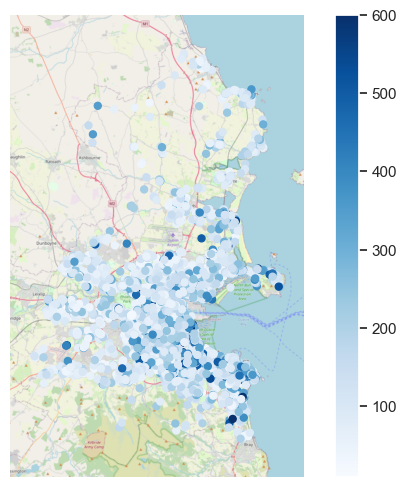

In [113]:
price = 600

axs = gplt.webmap(dub_listings_gpd.query('price <= {}'.format(price)), projection=gcrs.WebMercator())
gplt.pointplot(dub_listings_gpd.query('price <= {}'.format(price)), ax=axs, hue= 'price', cmap='Blues', legend=True)

There's alot of overlapping points in here, and the scale of the map makes is especially hard to see any specific clustering or trends within in the city limits
So it might be a good idea to make a selection based off of where the majority of the points seem to fall within

We can start by looking at the distribution of points in latitude and longitude

/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

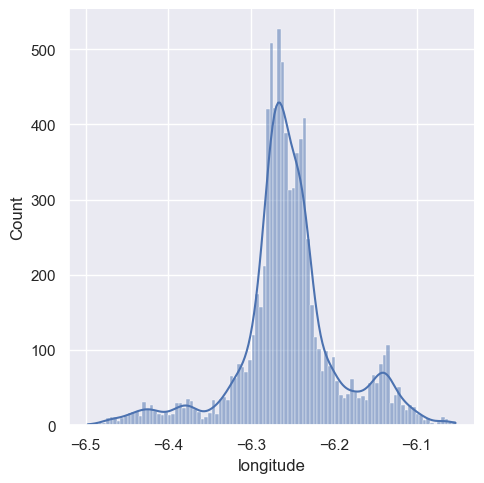

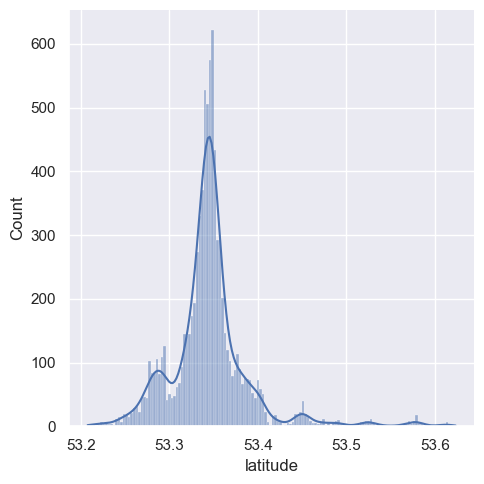

In [114]:
sns.displot(dub_listings.longitude, kde=True)
sns.displot(dub_listings.latitude, kde=True)

As expected, we can see that the majority of points cluster around coordinates `53.35,-6.25`, i.e central Dublin or the Dublin 1 postal district
But, interestingly too, we see some secondary clustering along latitude 53.28 and longitude -6.15. These taken together would correspond roughly correspond to the south-eastern areas of the county, which historically have been considered the more economically affluent Southside

With this knowledge, we can then make a selection cut for our listings dataframe based on lat,long, and pass these to a new geodataframe to try and focus on the more tightly clustered areas

<GeoAxes: >

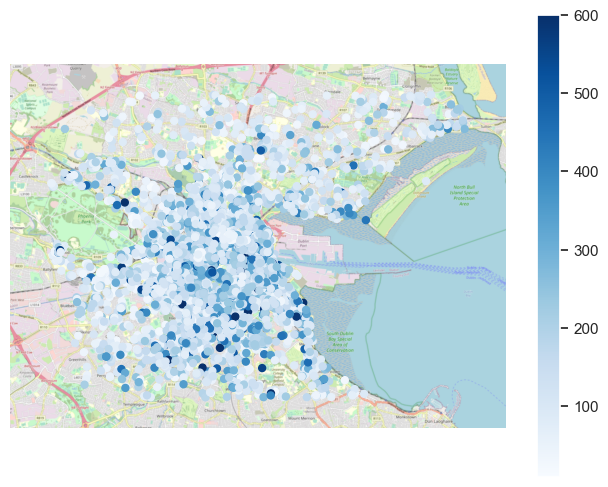

In [115]:
min_lat = 53.3
max_lat = 53.4
min_long = -6.35
max_long = -6.12

dub_listings_cut = dub_listings.query('(latitude > {}) & (latitude < {}) & (longitude > {}) & (longitude < {})'.format(min_lat, max_lat, min_long, max_long))
dub_listings_gpd_cut = gpd.GeoDataFrame(dub_listings_cut, geometry=gpd.points_from_xy(dub_listings_cut.longitude, dub_listings_cut.latitude,crs=4326))

len(dub_listings_cut)

price = 600

axs = gplt.webmap(dub_listings_gpd_cut.query('price <= {}'.format(price)), projection=gcrs.WebMercator())
gplt.pointplot(dub_listings_gpd_cut.query('price <= {}'.format(price)), ax=axs, hue= 'price', cmap='Blues',alpha=1, legend=True)

From the above, there's afew immediately visible trends;

- Majority of properties are in and around the median price
- Theres a reasonable variation in the price hue (from above, where we called .describe for the listings, we saw price had a std of ~€560)
- There is a noticeable price disparity between the Northside and Southside (more darker points south of the River Liffy)
- The absolute darkest points dont occure often

/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

<GeoAxes: >

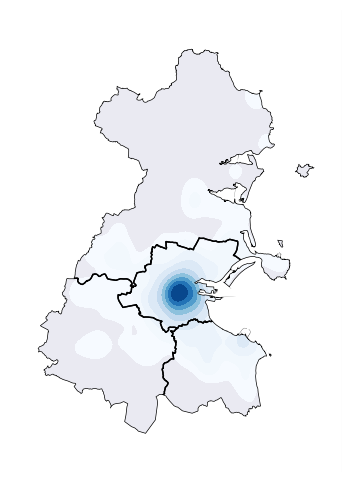

In [116]:
dub_geofile = './neighbourhoods.geojson'
dublin_geo = gpd.read_file(dub_geofile)
dublin_geo = dublin_geo.to_crs(4326)

axs = gplt.kdeplot(dub_listings_gpd, fill=True, cmap='Blues', clip=dublin_geo.geometry, projection=gcrs.WebMercator())

gplt.polyplot(dublin_geo, ax=axs, zorder=1)

To advance this, a good addition would be the use of Folium package to provide interactivity for the map and being able to view the data points in bins based on price 

From here, we'll use the `dub_listings_cut` dataframe to work with and just assign it to the dub_listings variable name
Firstly, we have to divide the prices into actual price bins (going to do it in blocks of €50 here)

In [117]:
dub_listings = dub_listings_cut

labels=['0-50','50-100','100-150','150-200','200-250','250-300','300-350','350-400','400-450','450-500','500+']
c_map = {'0-50':'skyblue','50-100':'dodgerblue','100-150':'blue','150-200':'blueviolet','200-250':'purple','250-300':'deeppink','300-350':'crimson','350-400':'orangered','400-450':'maroon','450-500':'orange','500+':'red'}

dub_listings['price_bins'] = pd.cut(dub_listings.price,bins=[-Inf,50,100,150,200,250,300,350,400,450,500,Inf], 
                                        labels=labels)
dub_listings['colors'] = dub_listings.price_bins.map(c_map) 

In [119]:
#declare a new folium map centred on Dublin city
folium_map = folium.Map(location=[53.30,-6.25],zoom_start=10)

#for each coordinate and its corresponding color, add a circle point to the map
for lat, lon, ptcolor in zip(dub_listings.latitude, dub_listings.longitude, dub_listings.colors):
  folium.CircleMarker(
     location=[lat, lon],
     radius=2,
     opacity=0.5,
     color=ptcolor,
     fill=True,
     fill_color=ptcolor,
  ).add_to(folium_map)


#get the coord and price data from the listings and convert to numpy list
dat = dub_listings[['latitude','longitude', 'price']].values
dat =dat.tolist()

#in addition to the individual point values, can add a heatmap showing the kernel density of price, going
#from least dense (blue/green) to most dense (red)
hm = plugins.HeatMap(dat,gradient={0.1: 'blue', 0.2: 'green', 0.4: 'yellow', 0.6: 'orange', 0.9: 'red'}, 
                min_opacity=0.1, 
                max_opacity=0.9, 
                radius=20,
                use_local_extrema=False)

# Add to base map
hm.add_to(folium_map)

folum_map.add_l

# Display
folium_map